In [1]:
import calendar
import csv
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sympy as sym
import tweepy

from sklearn.linear_model import LinearRegression
from scipy import stats

from secrets import *

%matplotlib inline

/home/vince/anaconda3/envs/dogrates/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data collection

Download the data from twitter using the [tweepy](http://www.tweepy.org) library.

In [2]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
datafile_path = "./data/main.csv"
columns = ["created_at", "full_text", "like_count", "retweet_count"]

In [4]:
df = pd.read_csv(datafile_path, header=None, names=columns)
last_tweet_date = pd.to_datetime(df["created_at"]).max()
num_new_tweets = 0

with open(datafile_path, "a") as f:
    csv_writer = csv.writer(f)
    for tweet in tweepy.Cursor(api.user_timeline, tweet_mode="extended", screen_name='@dog_rates').items():
        if tweet.created_at > last_tweet_date or last_tweet_date is pd.NaT:
            csv_writer.writerow([tweet.created_at, tweet.full_text, tweet.favorite_count, tweet.retweet_count])
            num_new_tweets += 1
print(f"{num_new_tweets} new tweets collected since {last_tweet_date}")

2 new tweets collected since 2018-03-28 01:38:23


In [5]:
df = pd.read_csv(datafile_path, 
                 names=["created_at", "full_text", "like_count", "retweet_count"])
df.drop_duplicates(subset="created_at", inplace=True)  # Just in case
df = df.sort_values("created_at")

df = pd.read_csv(datafile_path, 
                 names=["created_at", "full_text", "like_count", "retweet_count"])
df.drop_duplicates(subset="created_at", inplace=True)  # Just in case
df = df.sort_values("created_at")

df["created_at"] = pd.to_datetime(df["created_at"])


df["full_text_len"] = df["full_text"].str.len()

scores_df = df["full_text"].str.extract(r"(?P<score>\d+)/(?P<scale>\d+)", expand=True)
df = pd.concat([df, scores_df], axis=1)

for col in ["score", "scale"]:
    df[col] = pd.to_numeric(df[col])
df.head()

,created_at,full_text,like_count,retweet_count,full_text_len,score,scale
3219,2017-02-20 00:53:27,This is Poppy. She just arrived. 13/10 would s...,16007,2296,86,13.0,10.0
3218,2017-02-20 04:41:25,"@JenLiaLongo :,) @GoodDogsGame",14,0,30,NaN,NaN
3217,2017-02-20 17:00:04,This is Bronte. She's fairly h*ckin aerodynami...,22256,3565,164,13.0,10.0
3216,2017-02-20 17:09:13,"No, I did not expect @jk_rowling to have a dog...",7611,496,82,NaN,NaN
3215,2017-02-20 17:10:07,@thatswattsup @jk_rowling yes,504,7,29,NaN,NaN


In [6]:
df = df[(df["scale"] == 10) 
        & (df["score"] < 20) 
        & (df["score"] > 0) 
        & (df["full_text"].str[0] != "@")
        & (df["full_text"].str[:2] != "RT")]

In [7]:
df.head()

,created_at,full_text,like_count,retweet_count,full_text_len,score,scale
3219,2017-02-20 00:53:27,This is Poppy. She just arrived. 13/10 would s...,16007,2296,86,13.0,10.0
3217,2017-02-20 17:00:04,This is Bronte. She's fairly h*ckin aerodynami...,22256,3565,164,13.0,10.0
3208,2017-02-20 23:50:09,Meet Charlie. She asked u to change the channe...,16504,3828,163,13.0,10.0
3205,2017-02-21 02:17:06,This is Bentley. Hairbrushes are his favorite ...,14447,2671,126,12.0,10.0
3200,2017-02-21 17:04:24,This is Lipton. He's a West Romanian Snuggle P...,14069,2462,119,12.0,10.0


# Relationship between retweets and likes

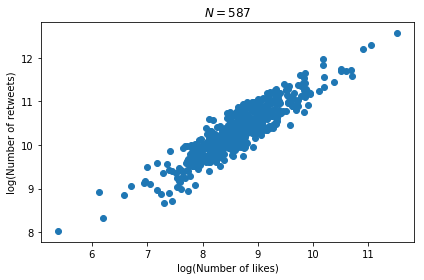

In [8]:
X = np.log(df["retweet_count"])
Y = np.log(df["like_count"])
plt.figure()
plt.scatter(X, Y)
plt.xlabel("log(Number of likes)")
plt.ylabel("log(Number of retweets)")
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/log_retweets_v_log_likes.png", dpi=1000)

In [9]:
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result = model.fit()
a_val, b_val = result.params["retweet_count"], result.params["const"]
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             like_count   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2607.
Date:                Wed, 28 Mar 2018   Prob (F-statistic):          1.03e-217
Time:                        18:31:43   Log-Likelihood:                -18.975
No. Observations:                 587   AIC:                             41.95
Df Residuals:                     585   BIC:                             50.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6067      0.132     27.303      0.000       3.347       3.866
retweet_count     0.7793      0.015     51.059      0.000       0.749       0.809
==============================================================================
Omnibus:                        6.418   Durbin-Watson:                   0.765
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                4.407
Skew:                          -0.039   Prob(JB):                        0.110
Kurtosis:                       2.583   Cond. No.                         112.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This implies that there's a pretty good relationship between a retweet and a like:

$$\log(Y)\approx a\log(X) + b$$

which can be simplified to give:

$$Y = e ^ {{a}\log(x) + b}$$

In [10]:
y, x, a, b = sym.symbols("y, x, a, b")
solution = sym.solveset(sym.log(y) - a * sym.log(x) - b, y)
solution

{exp(a*log(x) + b)}

In [11]:
a_val, b_val

(0.7793076714782076, 3.6067252403547325)

In [12]:
expr = list(solution)[0]
f = sym.lambdify(x, expr.subs({a: a_val, b: b_val}))

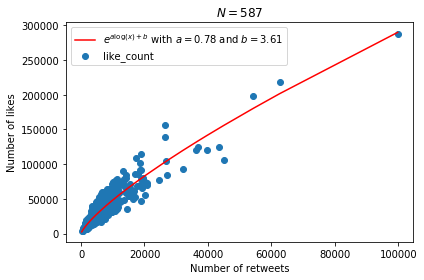

In [13]:
X = df["retweet_count"]
Y = df["like_count"]
plt.figure()
plt.scatter(X, Y)
plt.plot(np.sort(X), f(np.sort(X)), color="red", 
         label=f"${sym.latex(expr)}$ with $a={a_val: .2f}$ and $b={b_val: .2f}$")
plt.xlabel("Number of retweets")
plt.ylabel("Number of likes")
plt.title(f"$N = {len(df.index)}$")
plt.legend()
plt.tight_layout()
plt.savefig("./img/retweets_v_likes.png", dpi=1000)

# How do likes and retweets change over time?

## Likes

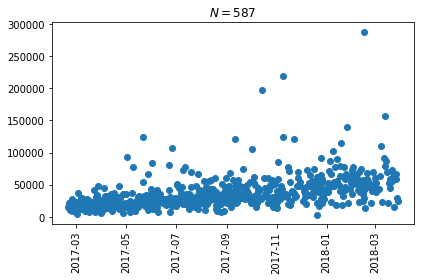

In [14]:
plt.figure()
plt.plot_date(df["created_at"], df["like_count"])
plt.xticks(rotation=90)
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/likes_v_time.png", dpi=1000);

In [15]:
model = LinearRegression()
X = np.array(df.index).reshape(-1, 1)
Y = df["like_count"]
model.fit(X, Y)
df["like_count_trend"] = model.predict(X)
df["like_count_detrended"] = df["like_count"] - df["like_count_trend"]

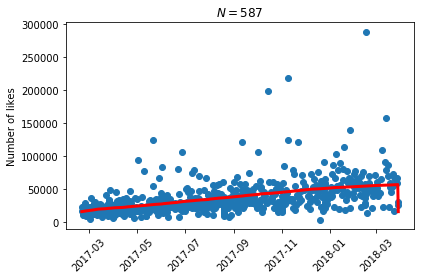

In [16]:
plt.figure()
plt.plot_date(df["created_at"], df["like_count"])
plt.plot_date(df["created_at"], df["like_count_trend"], 
              linestyle='solid', 
              marker='None', 
              color='red',
              linewidth=3)
plt.xticks(rotation=45)
plt.ylabel("Number of likes")
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/likes_v_tweets_with_trend.png", dpi=1000)

We have an upward trend (probably related to a constant growth in followers).

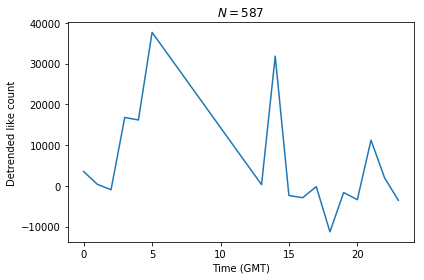

In [17]:
plt.figure()
plt.plot(df[["like_count_detrended"]].groupby(df["created_at"].dt.hour).mean())
plt.xlabel("Time (GMT)")
plt.ylabel("Detrended like count")
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/likes_v_hour.png", dpi=1000)

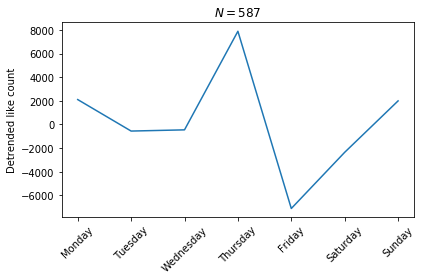

In [18]:
plt.plot(df[["like_count_detrended"]].groupby(df["created_at"].dt.dayofweek).mean())
days_of_the_week = [calendar.day_name[i] for i in range(7)]
plt.xticks(range(7), days_of_the_week, rotation=45)
plt.ylabel("Detrended like count")
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/likes_v_day.png", dpi=1000);

# Are all dogs appreciated appropriately?

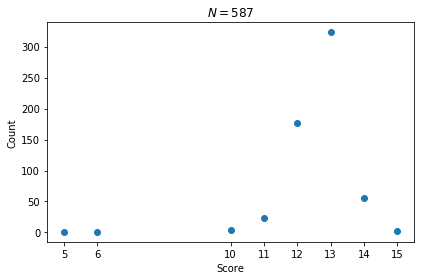

In [19]:
counts = df.groupby("score")["created_at"].count()

plt.scatter(counts.index, counts)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title(f"$N = {len(df.index)}$")
plt.xticks(counts.index)
plt.tight_layout()
plt.savefig("./img/count_v_score.png", dpi=1000)

/home/vince/anaconda3/envs/dogrates/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


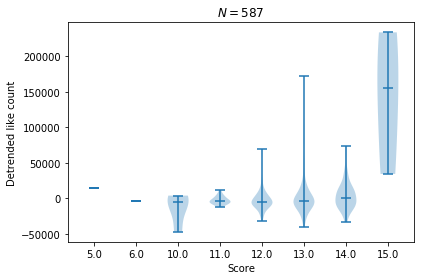

In [20]:
scores, series = zip(*df.groupby("score")["like_count_detrended"])
plt.figure()
plt.violinplot(series, showmedians=True)
plt.xticks(range(1, len(scores) + 1), scores)
plt.xlabel("Score")
plt.ylabel("Detrended like count")
plt.title(f"$N = {len(df.index)}$")
plt.tight_layout()
plt.savefig("./img/likes_v_score.png", dpi=1000);

In [21]:
f_val, p_val = stats.f_oneway(*series)
p_val

6.697329389076403e-27

Looking at just the 11-14:

In [22]:
f_val, p_val = stats.f_oneway(*series[3:-1])
p_val

0.07005535661644875